## 1. 필요한 라이브러리 임포트

In [1]:
# 주요 패키지
import numpy as np
import pandas as pd
import os 
from pathlib import Path
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

# 직접 개발한 패키지
from utils.config import CONFIG
from utils.visualize import visualize_data
from modules.input import TimeSeriesDownSampler

from training.model_training import create_lstm_autoencoder
from training.data_preprocessing import create_sequences
from lstmae import LSTMAutoencoder

# 딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from enum import Enum
class ModelType(Enum):
    VIB = 1
    VOLT = 2
    TEMP = 3

feature_types = {
    ModelType.VIB : 'vib',
    ModelType.VOLT : 'volt',
    ModelType.TEMP : 'temp'
}

2024-12-16 14:02:38.999351: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 14:02:39.021572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 14:02:39.355818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 새 모델을 만들 때마다 이 부분을 수정해주세요
model_type = ModelType.VOLT
lookback = 5

In [3]:
scaler_name = 'scaler_' + feature_types[model_type] + '_' + str(lookback)
model_name = feature_types[model_type] + '_' + str(lookback)

In [15]:
model_path = Path('../models') / (model_name + '.pth')
scaler_path = Path('../models') / (scaler_name + '.joblib')
data_path = Path('../datas')
normal_data_path = Path('../datas/normal') / (feature_types[model_type])
abnormal_data_path = Path('../datas/abnormal') / (feature_types[model_type])
model_dim = 3 if model_type == ModelType.VIB else 1

In [16]:
print(model_path)
print(scaler_path)
print(normal_data_path)
print(abnormal_data_path)
print(model_dim)

../models/volt_5.pth
../models/scaler_volt_5.joblib
../datas/normal/volt
../datas/abnormal/volt
1


## 2. 데이터 로드 및 전처리 함수 정의

In [6]:
# 1. 세션 파일 로딩
def load_session(file_path):
    """
    단일 세션 데이터를 로드하는 함수
    file_path 경로의 데이터를 로드하여 가속도 데이터만을 골라
    데이터프레임으로 반환
    """
    df = pd.read_csv(file_path)
    # 필요한 데이터의 칼럼만 선택
    columns = []
    if model_type == ModelType.VIB:
        columns = ['accel_x', 'accel_y', 'accel_z']
    elif model_type == ModelType.VOLT:
        columns = ['voltage']
    elif model_type == ModelType.TEMP:
        columns = ['temperature']
    return df[columns].values

In [7]:
# 2. 세션 하나(data)로 시퀀스들 생성
def create_sequences(df, sequence_length=5, step_size=3):
    """
    시계열 데이터를 시퀀스로 변환하는 함수
    데이터를 길이 sequence_length의 시퀀스들로 step size만큼 이동하며 생성
    생성된 시퀀스들의 배열을 반환
    """
    sequences = []
    for i in range(0, len(df) - sequence_length + 1, step_size):
        sequence = df[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [8]:
# 3. 정상 시퀀스 생성
def prepare_normal_data(normal_data_dir):
    """
    각 세션별로 균등하게 분할하여 데이터셋 준비
    위 함수들을 이용해 데이터셋 준비
    세션-시퀀스 쌍 딕셔너리 배열을 만든 다음
    각 세션 별로 시퀀스들을 70:20:10으로 분할
    
    train sequence에 대해 스케일러 학습시키고
    이 스케일러로 validation seq, test seq도 적용용
    """
    data_dir = Path(normal_data_dir)
    
    # 각 세션별로 시퀀스 생성
    session_sequences = []
    for file_path in data_dir.glob('*.csv'):
        print(file_path)
        session_data = load_session(file_path)
        sequences = create_sequences(session_data)
        session_sequences.append({
            'file_name': file_path.name,
            'sequences': sequences
        })
    
    # 각 세션별로 70:20:10 분할
    train_sequences = []
    val_sequences = []
    test_sequences = []
    
    for session in session_sequences:
        sequences = session['sequences']
        n_sequences = len(sequences)
        
        # 인덱스 무작위 섞기
        indices = np.random.permutation(n_sequences)
        
        # 비율에 따라 분할
        n_train = int(n_sequences * 0.7)
        n_val = int(n_sequences * 0.2)
        
        train_idx = indices[:n_train]
        val_idx = indices[n_train:n_train + n_val]
        test_idx = indices[n_train + n_val:]
        
        train_sequences.append(sequences[train_idx])
        val_sequences.append(sequences[val_idx])
        test_sequences.append(sequences[test_idx])
        
        print(f"Session {session['file_name']}: {len(sequences)} sequences")
        print(f"  - Train: {len(train_idx)}")
        print(f"  - Val: {len(val_idx)}")
        print(f"  - Test: {len(test_idx)}")
    
    # 각 세트 내에서 세션 데이터 합치기
    train_sequences = np.concatenate(train_sequences)
    val_sequences = np.concatenate(val_sequences)
    test_sequences = np.concatenate(test_sequences)
    
    # 스케일러 학습 (훈련 데이터만 사용)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    train_sequences_2d = train_sequences.reshape(-1, train_sequences.shape[-1])
    scaler.fit(train_sequences_2d)
    
    # 스케일러 저장
    dump(scaler, scaler_path)
    print(f"\nScaler saved to {scaler_path}")
    
    def scale_sequences(sequences):
        original_shape = sequences.shape
        sequences_2d = sequences.reshape(-1, sequences.shape[-1])
        scaled_2d = scaler.transform(sequences_2d)
        return scaled_2d.reshape(original_shape)
    
    # 모든 데이터 스케일링
    train_sequences_scaled = scale_sequences(train_sequences)
    val_sequences_scaled = scale_sequences(val_sequences)
    test_sequences_scaled = scale_sequences(test_sequences)
    
    return {
        'train': train_sequences_scaled,
        'val': val_sequences_scaled,
        'test_normal': test_sequences_scaled,
        'scaler': scaler
    }

In [9]:
# 4. 스케일러 로딩
def load_scaler(models_dir='models'):
    """저장된 스케일러를 불러오는 함수"""
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler file not found at {scaler_path}")
    return load(scaler_path)

In [10]:
# 5. 테스트 시퀀스 준비
def prepare_test_data(abnormal_data_dir):
    """저장된 스케일러를 사용하여 테스트 데이터를 준비하는 함수"""
    data_dir = Path(abnormal_data_dir)
    # 저장된 스케일러 로드
    scaler = load_scaler(scaler_path)
    
    # 이상치 데이터 로드
    abnormal_sequences = []
    for file_path in data_dir.glob('*.csv'):
        print(file_path)
        session_data = load_session(file_path)
        sequences = create_sequences(session_data)
        abnormal_sequences.extend(sequences)
    abnormal_sequences = np.array(abnormal_sequences)
    
    # 이상치 데이터 스케일링
    def scale_sequences(sequences):
        original_shape = sequences.shape
        sequences_2d = sequences.reshape(-1, sequences.shape[-1])
        scaled_2d = scaler.transform(sequences_2d)
        return scaled_2d.reshape(original_shape)
    
    abnormal_sequences_scaled = scale_sequences(abnormal_sequences)
    
    return {'abnormal': abnormal_sequences_scaled}

In [11]:
# 6. 데이터셋 클래스
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.FloatTensor(sequences)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

## 3. 모델 클래스 정의(lstmae.py에서 했음)

## 4. 모델 학습 함수 정의

In [12]:
def train_model(model, train_loader, val_loader, 
                n_epochs=100, learning_rate=1e-3, 
                device='cuda' if torch.cuda.is_available() else 'cpu',
                patience=10, model_save_path=model_path):
    """
    LSTM Autoencoder 모델 훈련 함수
    
    Args:
        model: LSTM Autoencoder 모델
        train_loader: 훈련 데이터 로더
        val_loader: 검증 데이터 로더
        n_epochs: 전체 에포크 수
        learning_rate: 학습률
        device: 학습 디바이스 (CPU/GPU)
        patience: Early stopping patience
        model_save_path: 모델 저장 경로
    """
    # 모델을 지정된 디바이스로 이동
    model = model.to(device)
    
    # 손실 함수와 옵티마이저 정의
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Early stopping 관련 변수들
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop = False
    
    # 훈련 과정 모니터링을 위한 리스트
    train_losses = []
    val_losses = []
    
    # 모델 저장 경로 설정
    model_save_path = Path(model_save_path)
    model_save_path.parent.mkdir(exist_ok=True)
    
    for epoch in range(n_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_batches = 0
        
        # 훈련 루프
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
            batch = batch.to(device)
            
            # 순전파
            output = model(batch)
            loss = criterion(output, batch)
            
            # 역전파 및 옵티마이저 스텝
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        # 에포크당 평균 훈련 손실 계산
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch)
                val_loss += loss.item()
                val_batches += 1
        
        # 에포크당 평균 검증 손실 계산
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # 현재 상태 출력
        print(f'Epoch [{epoch+1}/{n_epochs}]')
        print(f'  Training Loss: {avg_train_loss:.6f}')
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        
        # Early stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # 최상의 모델 저장
            torch.save(model.state_dict(), model_save_path)
            print(f'  Model saved to {model_save_path}')
        else:
            patience_counter += 1
            print(f'  EarlyStopping counter: {patience_counter} out of {patience}')
            
        if patience_counter >= patience:
            print('Early stopping triggered')
            early_stop = True
            break
    
    # 학습 과정 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

def load_trained_model(model, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    저장된 모델 가중치를 로드하는 함수
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [13]:
def evaluate_model(model, test_loader, test_labels, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    모델 평가 및 다양한 메트릭 계산/시각화
    
    Args:
        model: 학습된 LSTM Autoencoder 모델
        test_loader: 테스트 데이터 로더
        test_labels: 테스트 데이터의 실제 레이블 (0: 정상, 1: 이상)
        device: 평가 수행할 디바이스
    """
    model.eval()
    reconstruction_errors = []
    
    # 재구성 오차 계산
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            # 각 샘플의 재구성 오차 계산
            errors = torch.mean((batch - output) ** 2, dim=(1, 2))
            
            # MinMaxScaler에 맞는 상대 오차로 변경
            #relative_error = torch.abs(batch - output) / (torch.abs(batch) + 1e-6)
            #errors = torch.mean(relative_error, dim=(1, 2))
            reconstruction_errors.extend(errors.cpu().numpy())
    
    reconstruction_errors = np.array(reconstruction_errors)
    
    # 1. 재구성 오차 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors[test_labels == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(reconstruction_errors[test_labels == 1], bins=50, alpha=0.5, label='Anomaly', density=True)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.show()
    
    # 2. ROC 커브
    fpr, tpr, roc_thresholds = roc_curve(test_labels, reconstruction_errors)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # 3. Precision-Recall 커브
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # 4. 최적 임계값 찾기
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_threshold_idx = np.argmax(f1_scores)
    optimal_threshold = pr_thresholds[optimal_threshold_idx]
    
    # 5. 혼동 행렬
    predictions = (reconstruction_errors >= optimal_threshold).astype(int)
    cm = confusion_matrix(test_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (threshold = {optimal_threshold:.4f})')
    plt.show()
    
    # 6. 성능 지표 계산
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    f1 = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    
    print("\nPerformance Metrics:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"Recall: {recall_score:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    return {
        'reconstruction_errors': reconstruction_errors,
        'optimal_threshold': optimal_threshold,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'f1_score': f1
    }

## 5. 학습 및 테스트 진행

../datas/normal/volt/downsampled_600-8_loss.csv
../datas/normal/volt/downsampled_600-9.csv
../datas/normal/volt/downsampled_600-3.csv
../datas/normal/volt/downsampled_600-2.csv
../datas/normal/volt/downsampled_600-1.csv
../datas/normal/volt/600-11-1.csv
../datas/normal/volt/downsampled_600-6.csv
Session downsampled_600-8_loss.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-9.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-3.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-2.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session downsampled_600-1.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61
Session 600-11-1.csv: 509 sequences
  - Train: 356
  - Val: 101
  - Test: 52
Session downsampled_600-6.csv: 599 sequences
  - Train: 419
  - Val: 119
  - Test: 61

Scaler saved to ../models/scaler_volt_5.joblib
../datas/abnormal/volt/voltage-low.csv
../datas/abnormal/

Epoch 1/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 90/90 [00:00<00:00, 366.21it/s]


Epoch [1/100]
  Training Loss: 0.436870
  Validation Loss: 0.146056
  Model saved to ../models/volt_5.pth


Epoch 2/100: 100%|██████████| 90/90 [00:00<00:00, 624.05it/s]


Epoch [2/100]
  Training Loss: 0.110046
  Validation Loss: 0.102416
  Model saved to ../models/volt_5.pth


Epoch 3/100: 100%|██████████| 90/90 [00:00<00:00, 642.58it/s]


Epoch [3/100]
  Training Loss: 0.098885
  Validation Loss: 0.095517
  Model saved to ../models/volt_5.pth


Epoch 4/100: 100%|██████████| 90/90 [00:00<00:00, 623.89it/s]


Epoch [4/100]
  Training Loss: 0.096321
  Validation Loss: 0.097630
  EarlyStopping counter: 1 out of 10


Epoch 5/100: 100%|██████████| 90/90 [00:00<00:00, 557.20it/s]


Epoch [5/100]
  Training Loss: 0.095275
  Validation Loss: 0.093263
  Model saved to ../models/volt_5.pth


Epoch 6/100: 100%|██████████| 90/90 [00:00<00:00, 636.55it/s]


Epoch [6/100]
  Training Loss: 0.092627
  Validation Loss: 0.089086
  Model saved to ../models/volt_5.pth


Epoch 7/100: 100%|██████████| 90/90 [00:00<00:00, 606.82it/s]


Epoch [7/100]
  Training Loss: 0.089489
  Validation Loss: 0.087576
  Model saved to ../models/volt_5.pth


Epoch 8/100: 100%|██████████| 90/90 [00:00<00:00, 582.57it/s]


Epoch [8/100]
  Training Loss: 0.087146
  Validation Loss: 0.084092
  Model saved to ../models/volt_5.pth


Epoch 9/100: 100%|██████████| 90/90 [00:00<00:00, 633.14it/s]


Epoch [9/100]
  Training Loss: 0.082084
  Validation Loss: 0.081301
  Model saved to ../models/volt_5.pth


Epoch 10/100: 100%|██████████| 90/90 [00:00<00:00, 547.28it/s]


Epoch [10/100]
  Training Loss: 0.079559
  Validation Loss: 0.075715
  Model saved to ../models/volt_5.pth


Epoch 11/100: 100%|██████████| 90/90 [00:00<00:00, 610.54it/s]


Epoch [11/100]
  Training Loss: 0.077367
  Validation Loss: 0.074508
  Model saved to ../models/volt_5.pth


Epoch 12/100: 100%|██████████| 90/90 [00:00<00:00, 618.46it/s]


Epoch [12/100]
  Training Loss: 0.074805
  Validation Loss: 0.071807
  Model saved to ../models/volt_5.pth


Epoch 13/100: 100%|██████████| 90/90 [00:00<00:00, 546.27it/s]


Epoch [13/100]
  Training Loss: 0.073247
  Validation Loss: 0.074133
  EarlyStopping counter: 1 out of 10


Epoch 14/100: 100%|██████████| 90/90 [00:00<00:00, 532.75it/s]


Epoch [14/100]
  Training Loss: 0.071789
  Validation Loss: 0.073835
  EarlyStopping counter: 2 out of 10


Epoch 15/100: 100%|██████████| 90/90 [00:00<00:00, 634.69it/s]


Epoch [15/100]
  Training Loss: 0.070602
  Validation Loss: 0.067612
  Model saved to ../models/volt_5.pth


Epoch 16/100: 100%|██████████| 90/90 [00:00<00:00, 595.42it/s]


Epoch [16/100]
  Training Loss: 0.067528
  Validation Loss: 0.059764
  Model saved to ../models/volt_5.pth


Epoch 17/100: 100%|██████████| 90/90 [00:00<00:00, 591.30it/s]


Epoch [17/100]
  Training Loss: 0.058615
  Validation Loss: 0.052380
  Model saved to ../models/volt_5.pth


Epoch 18/100: 100%|██████████| 90/90 [00:00<00:00, 554.74it/s]


Epoch [18/100]
  Training Loss: 0.054756
  Validation Loss: 0.051524
  Model saved to ../models/volt_5.pth


Epoch 19/100: 100%|██████████| 90/90 [00:00<00:00, 568.15it/s]


Epoch [19/100]
  Training Loss: 0.053312
  Validation Loss: 0.049806
  Model saved to ../models/volt_5.pth


Epoch 20/100: 100%|██████████| 90/90 [00:00<00:00, 590.39it/s]


Epoch [20/100]
  Training Loss: 0.050767
  Validation Loss: 0.047913
  Model saved to ../models/volt_5.pth


Epoch 21/100: 100%|██████████| 90/90 [00:00<00:00, 624.09it/s]


Epoch [21/100]
  Training Loss: 0.049946
  Validation Loss: 0.046635
  Model saved to ../models/volt_5.pth


Epoch 22/100: 100%|██████████| 90/90 [00:00<00:00, 639.55it/s]


Epoch [22/100]
  Training Loss: 0.048662
  Validation Loss: 0.047083
  EarlyStopping counter: 1 out of 10


Epoch 23/100: 100%|██████████| 90/90 [00:00<00:00, 649.13it/s]


Epoch [23/100]
  Training Loss: 0.048625
  Validation Loss: 0.047722
  EarlyStopping counter: 2 out of 10


Epoch 24/100: 100%|██████████| 90/90 [00:00<00:00, 710.78it/s]


Epoch [24/100]
  Training Loss: 0.048213
  Validation Loss: 0.045362
  Model saved to ../models/volt_5.pth


Epoch 25/100: 100%|██████████| 90/90 [00:00<00:00, 633.04it/s]


Epoch [25/100]
  Training Loss: 0.046900
  Validation Loss: 0.045954
  EarlyStopping counter: 1 out of 10


Epoch 26/100: 100%|██████████| 90/90 [00:00<00:00, 541.87it/s]


Epoch [26/100]
  Training Loss: 0.045945
  Validation Loss: 0.043670
  Model saved to ../models/volt_5.pth


Epoch 27/100: 100%|██████████| 90/90 [00:00<00:00, 659.74it/s]


Epoch [27/100]
  Training Loss: 0.044978
  Validation Loss: 0.041136
  Model saved to ../models/volt_5.pth


Epoch 28/100: 100%|██████████| 90/90 [00:00<00:00, 662.24it/s]


Epoch [28/100]
  Training Loss: 0.039887
  Validation Loss: 0.033402
  Model saved to ../models/volt_5.pth


Epoch 29/100: 100%|██████████| 90/90 [00:00<00:00, 664.84it/s]


Epoch [29/100]
  Training Loss: 0.032907
  Validation Loss: 0.028093
  Model saved to ../models/volt_5.pth


Epoch 30/100: 100%|██████████| 90/90 [00:00<00:00, 614.00it/s]


Epoch [30/100]
  Training Loss: 0.030191
  Validation Loss: 0.027181
  Model saved to ../models/volt_5.pth


Epoch 31/100: 100%|██████████| 90/90 [00:00<00:00, 650.97it/s]


Epoch [31/100]
  Training Loss: 0.029256
  Validation Loss: 0.026125
  Model saved to ../models/volt_5.pth


Epoch 32/100: 100%|██████████| 90/90 [00:00<00:00, 616.20it/s]


Epoch [32/100]
  Training Loss: 0.027903
  Validation Loss: 0.023461
  Model saved to ../models/volt_5.pth


Epoch 33/100: 100%|██████████| 90/90 [00:00<00:00, 613.71it/s]


Epoch [33/100]
  Training Loss: 0.027237
  Validation Loss: 0.022819
  Model saved to ../models/volt_5.pth


Epoch 34/100: 100%|██████████| 90/90 [00:00<00:00, 657.63it/s]


Epoch [34/100]
  Training Loss: 0.025848
  Validation Loss: 0.022479
  Model saved to ../models/volt_5.pth


Epoch 35/100: 100%|██████████| 90/90 [00:00<00:00, 656.69it/s]


Epoch [35/100]
  Training Loss: 0.025667
  Validation Loss: 0.021658
  Model saved to ../models/volt_5.pth


Epoch 36/100: 100%|██████████| 90/90 [00:00<00:00, 649.57it/s]


Epoch [36/100]
  Training Loss: 0.025731
  Validation Loss: 0.023536
  EarlyStopping counter: 1 out of 10


Epoch 37/100: 100%|██████████| 90/90 [00:00<00:00, 600.07it/s]


Epoch [37/100]
  Training Loss: 0.025397
  Validation Loss: 0.022585
  EarlyStopping counter: 2 out of 10


Epoch 38/100: 100%|██████████| 90/90 [00:00<00:00, 616.13it/s]


Epoch [38/100]
  Training Loss: 0.024966
  Validation Loss: 0.024066
  EarlyStopping counter: 3 out of 10


Epoch 39/100: 100%|██████████| 90/90 [00:00<00:00, 662.99it/s]


Epoch [39/100]
  Training Loss: 0.025019
  Validation Loss: 0.021243
  Model saved to ../models/volt_5.pth


Epoch 40/100: 100%|██████████| 90/90 [00:00<00:00, 530.65it/s]


Epoch [40/100]
  Training Loss: 0.024756
  Validation Loss: 0.022363
  EarlyStopping counter: 1 out of 10


Epoch 41/100: 100%|██████████| 90/90 [00:00<00:00, 649.77it/s]


Epoch [41/100]
  Training Loss: 0.024829
  Validation Loss: 0.020967
  Model saved to ../models/volt_5.pth


Epoch 42/100: 100%|██████████| 90/90 [00:00<00:00, 617.59it/s]


Epoch [42/100]
  Training Loss: 0.024221
  Validation Loss: 0.020278
  Model saved to ../models/volt_5.pth


Epoch 43/100: 100%|██████████| 90/90 [00:00<00:00, 592.00it/s]


Epoch [43/100]
  Training Loss: 0.023735
  Validation Loss: 0.020419
  EarlyStopping counter: 1 out of 10


Epoch 44/100: 100%|██████████| 90/90 [00:00<00:00, 628.51it/s]


Epoch [44/100]
  Training Loss: 0.023551
  Validation Loss: 0.021069
  EarlyStopping counter: 2 out of 10


Epoch 45/100: 100%|██████████| 90/90 [00:00<00:00, 561.54it/s]


Epoch [45/100]
  Training Loss: 0.023754
  Validation Loss: 0.020249
  Model saved to ../models/volt_5.pth


Epoch 46/100: 100%|██████████| 90/90 [00:00<00:00, 665.31it/s]


Epoch [46/100]
  Training Loss: 0.023293
  Validation Loss: 0.019585
  Model saved to ../models/volt_5.pth


Epoch 47/100: 100%|██████████| 90/90 [00:00<00:00, 614.53it/s]


Epoch [47/100]
  Training Loss: 0.021890
  Validation Loss: 0.018220
  Model saved to ../models/volt_5.pth


Epoch 48/100: 100%|██████████| 90/90 [00:00<00:00, 529.62it/s]


Epoch [48/100]
  Training Loss: 0.020458
  Validation Loss: 0.014583
  Model saved to ../models/volt_5.pth


Epoch 49/100: 100%|██████████| 90/90 [00:00<00:00, 556.80it/s]


Epoch [49/100]
  Training Loss: 0.015076
  Validation Loss: 0.010332
  Model saved to ../models/volt_5.pth


Epoch 50/100: 100%|██████████| 90/90 [00:00<00:00, 682.28it/s]


Epoch [50/100]
  Training Loss: 0.009957
  Validation Loss: 0.004253
  Model saved to ../models/volt_5.pth


Epoch 51/100: 100%|██████████| 90/90 [00:00<00:00, 644.21it/s]


Epoch [51/100]
  Training Loss: 0.008565
  Validation Loss: 0.004948
  EarlyStopping counter: 1 out of 10


Epoch 52/100: 100%|██████████| 90/90 [00:00<00:00, 671.91it/s]


Epoch [52/100]
  Training Loss: 0.007321
  Validation Loss: 0.002841
  Model saved to ../models/volt_5.pth


Epoch 53/100: 100%|██████████| 90/90 [00:00<00:00, 596.02it/s]


Epoch [53/100]
  Training Loss: 0.006406
  Validation Loss: 0.002619
  Model saved to ../models/volt_5.pth


Epoch 54/100: 100%|██████████| 90/90 [00:00<00:00, 620.63it/s]


Epoch [54/100]
  Training Loss: 0.006865
  Validation Loss: 0.001971
  Model saved to ../models/volt_5.pth


Epoch 55/100: 100%|██████████| 90/90 [00:00<00:00, 584.69it/s]


Epoch [55/100]
  Training Loss: 0.006182
  Validation Loss: 0.005144
  EarlyStopping counter: 1 out of 10


Epoch 56/100: 100%|██████████| 90/90 [00:00<00:00, 559.36it/s]


Epoch [56/100]
  Training Loss: 0.006376
  Validation Loss: 0.002608
  EarlyStopping counter: 2 out of 10


Epoch 57/100: 100%|██████████| 90/90 [00:00<00:00, 566.46it/s]


Epoch [57/100]
  Training Loss: 0.006077
  Validation Loss: 0.002779
  EarlyStopping counter: 3 out of 10


Epoch 58/100: 100%|██████████| 90/90 [00:00<00:00, 655.81it/s]


Epoch [58/100]
  Training Loss: 0.005974
  Validation Loss: 0.002521
  EarlyStopping counter: 4 out of 10


Epoch 59/100: 100%|██████████| 90/90 [00:00<00:00, 660.54it/s]


Epoch [59/100]
  Training Loss: 0.005218
  Validation Loss: 0.001843
  Model saved to ../models/volt_5.pth


Epoch 60/100: 100%|██████████| 90/90 [00:00<00:00, 621.29it/s]


Epoch [60/100]
  Training Loss: 0.005233
  Validation Loss: 0.001292
  Model saved to ../models/volt_5.pth


Epoch 61/100: 100%|██████████| 90/90 [00:00<00:00, 579.08it/s]


Epoch [61/100]
  Training Loss: 0.005281
  Validation Loss: 0.001487
  EarlyStopping counter: 1 out of 10


Epoch 62/100: 100%|██████████| 90/90 [00:00<00:00, 590.14it/s]


Epoch [62/100]
  Training Loss: 0.005274
  Validation Loss: 0.001861
  EarlyStopping counter: 2 out of 10


Epoch 63/100: 100%|██████████| 90/90 [00:00<00:00, 652.71it/s]


Epoch [63/100]
  Training Loss: 0.005407
  Validation Loss: 0.001775
  EarlyStopping counter: 3 out of 10


Epoch 64/100: 100%|██████████| 90/90 [00:00<00:00, 595.59it/s]


Epoch [64/100]
  Training Loss: 0.004934
  Validation Loss: 0.001850
  EarlyStopping counter: 4 out of 10


Epoch 65/100: 100%|██████████| 90/90 [00:00<00:00, 655.04it/s]


Epoch [65/100]
  Training Loss: 0.004994
  Validation Loss: 0.002168
  EarlyStopping counter: 5 out of 10


Epoch 66/100: 100%|██████████| 90/90 [00:00<00:00, 554.72it/s]


Epoch [66/100]
  Training Loss: 0.005124
  Validation Loss: 0.001613
  EarlyStopping counter: 6 out of 10


Epoch 67/100: 100%|██████████| 90/90 [00:00<00:00, 526.14it/s]


Epoch [67/100]
  Training Loss: 0.005395
  Validation Loss: 0.001298
  EarlyStopping counter: 7 out of 10


Epoch 68/100: 100%|██████████| 90/90 [00:00<00:00, 589.09it/s]


Epoch [68/100]
  Training Loss: 0.004725
  Validation Loss: 0.001267
  Model saved to ../models/volt_5.pth


Epoch 69/100: 100%|██████████| 90/90 [00:00<00:00, 610.55it/s]


Epoch [69/100]
  Training Loss: 0.005347
  Validation Loss: 0.002149
  EarlyStopping counter: 1 out of 10


Epoch 70/100: 100%|██████████| 90/90 [00:00<00:00, 554.54it/s]


Epoch [70/100]
  Training Loss: 0.004821
  Validation Loss: 0.001122
  Model saved to ../models/volt_5.pth


Epoch 71/100: 100%|██████████| 90/90 [00:00<00:00, 622.46it/s]


Epoch [71/100]
  Training Loss: 0.004383
  Validation Loss: 0.002278
  EarlyStopping counter: 1 out of 10


Epoch 72/100: 100%|██████████| 90/90 [00:00<00:00, 619.61it/s]


Epoch [72/100]
  Training Loss: 0.005100
  Validation Loss: 0.002486
  EarlyStopping counter: 2 out of 10


Epoch 73/100: 100%|██████████| 90/90 [00:00<00:00, 620.44it/s]


Epoch [73/100]
  Training Loss: 0.004910
  Validation Loss: 0.002182
  EarlyStopping counter: 3 out of 10


Epoch 74/100: 100%|██████████| 90/90 [00:00<00:00, 635.48it/s]


Epoch [74/100]
  Training Loss: 0.004758
  Validation Loss: 0.002181
  EarlyStopping counter: 4 out of 10


Epoch 75/100: 100%|██████████| 90/90 [00:00<00:00, 671.89it/s]


Epoch [75/100]
  Training Loss: 0.004252
  Validation Loss: 0.001390
  EarlyStopping counter: 5 out of 10


Epoch 76/100: 100%|██████████| 90/90 [00:00<00:00, 705.87it/s]


Epoch [76/100]
  Training Loss: 0.004536
  Validation Loss: 0.001889
  EarlyStopping counter: 6 out of 10


Epoch 77/100: 100%|██████████| 90/90 [00:00<00:00, 542.44it/s]


Epoch [77/100]
  Training Loss: 0.004577
  Validation Loss: 0.001175
  EarlyStopping counter: 7 out of 10


Epoch 78/100: 100%|██████████| 90/90 [00:00<00:00, 571.44it/s]


Epoch [78/100]
  Training Loss: 0.004346
  Validation Loss: 0.001653
  EarlyStopping counter: 8 out of 10


Epoch 79/100: 100%|██████████| 90/90 [00:00<00:00, 596.41it/s]


Epoch [79/100]
  Training Loss: 0.004416
  Validation Loss: 0.001090
  Model saved to ../models/volt_5.pth


Epoch 80/100: 100%|██████████| 90/90 [00:00<00:00, 576.28it/s]


Epoch [80/100]
  Training Loss: 0.004816
  Validation Loss: 0.002409
  EarlyStopping counter: 1 out of 10


Epoch 81/100: 100%|██████████| 90/90 [00:00<00:00, 566.57it/s]


Epoch [81/100]
  Training Loss: 0.004195
  Validation Loss: 0.000990
  Model saved to ../models/volt_5.pth


Epoch 82/100: 100%|██████████| 90/90 [00:00<00:00, 537.47it/s]


Epoch [82/100]
  Training Loss: 0.004229
  Validation Loss: 0.001570
  EarlyStopping counter: 1 out of 10


Epoch 83/100: 100%|██████████| 90/90 [00:00<00:00, 559.83it/s]


Epoch [83/100]
  Training Loss: 0.004212
  Validation Loss: 0.001902
  EarlyStopping counter: 2 out of 10


Epoch 84/100: 100%|██████████| 90/90 [00:00<00:00, 633.67it/s]


Epoch [84/100]
  Training Loss: 0.003992
  Validation Loss: 0.001778
  EarlyStopping counter: 3 out of 10


Epoch 85/100: 100%|██████████| 90/90 [00:00<00:00, 541.28it/s]


Epoch [85/100]
  Training Loss: 0.004379
  Validation Loss: 0.000827
  Model saved to ../models/volt_5.pth


Epoch 86/100: 100%|██████████| 90/90 [00:00<00:00, 662.94it/s]


Epoch [86/100]
  Training Loss: 0.004188
  Validation Loss: 0.002132
  EarlyStopping counter: 1 out of 10


Epoch 87/100: 100%|██████████| 90/90 [00:00<00:00, 592.61it/s]


Epoch [87/100]
  Training Loss: 0.004490
  Validation Loss: 0.002159
  EarlyStopping counter: 2 out of 10


Epoch 88/100: 100%|██████████| 90/90 [00:00<00:00, 675.41it/s]


Epoch [88/100]
  Training Loss: 0.004316
  Validation Loss: 0.001933
  EarlyStopping counter: 3 out of 10


Epoch 89/100: 100%|██████████| 90/90 [00:00<00:00, 615.42it/s]


Epoch [89/100]
  Training Loss: 0.003967
  Validation Loss: 0.001591
  EarlyStopping counter: 4 out of 10


Epoch 90/100: 100%|██████████| 90/90 [00:00<00:00, 628.29it/s]


Epoch [90/100]
  Training Loss: 0.004593
  Validation Loss: 0.002072
  EarlyStopping counter: 5 out of 10


Epoch 91/100: 100%|██████████| 90/90 [00:00<00:00, 582.03it/s]


Epoch [91/100]
  Training Loss: 0.004313
  Validation Loss: 0.001753
  EarlyStopping counter: 6 out of 10


Epoch 92/100: 100%|██████████| 90/90 [00:00<00:00, 527.01it/s]


Epoch [92/100]
  Training Loss: 0.004107
  Validation Loss: 0.001582
  EarlyStopping counter: 7 out of 10


Epoch 93/100: 100%|██████████| 90/90 [00:00<00:00, 537.52it/s]


Epoch [93/100]
  Training Loss: 0.003987
  Validation Loss: 0.001873
  EarlyStopping counter: 8 out of 10


Epoch 94/100: 100%|██████████| 90/90 [00:00<00:00, 498.42it/s]


Epoch [94/100]
  Training Loss: 0.004037
  Validation Loss: 0.001390
  EarlyStopping counter: 9 out of 10


Epoch 95/100: 100%|██████████| 90/90 [00:00<00:00, 637.81it/s]


Epoch [95/100]
  Training Loss: 0.004692
  Validation Loss: 0.002092
  EarlyStopping counter: 10 out of 10
Early stopping triggered


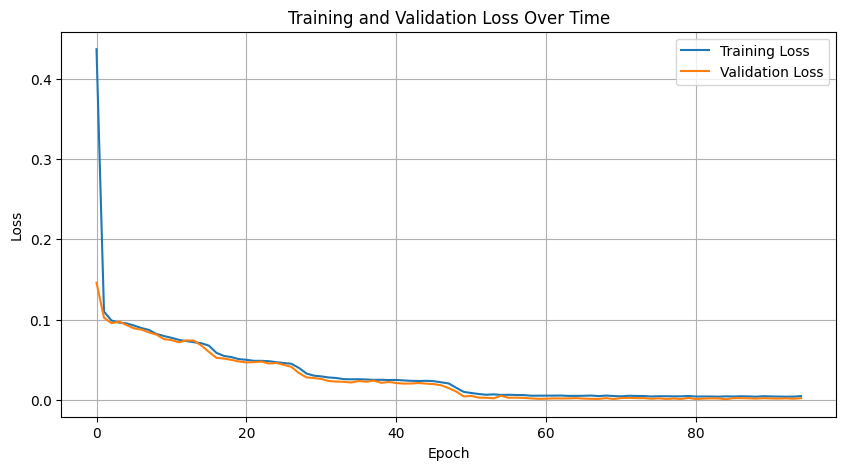

In [17]:
# 1. 데이터 준비
# 정상 데이터 준비 (훈련, 검증, 테스트용 정상 데이터)
normal_dataset = prepare_normal_data(normal_data_path)
# 이상치 데이터 준비
abnormal_dataset = prepare_test_data(abnormal_data_path)

# 2. 테스트 세트 구성
# 정상 테스트 데이터와 이상치 데이터 합치기
test_sequences = np.concatenate([
    normal_dataset['test_normal'],  # 정상 테스트 시퀀스
    abnormal_dataset['abnormal']    # 이상치 시퀀스
])

# 레이블 생성 (0: 정상, 1: 이상)
test_labels = np.concatenate([
    np.zeros(len(normal_dataset['test_normal'])),  # 정상 데이터 레이블
    np.ones(len(abnormal_dataset['abnormal']))     # 이상치 데이터 레이블
])
# Dataset과 DataLoader 생성
train_dataset = SequenceDataset(normal_dataset['train'])
val_dataset = SequenceDataset(normal_dataset['val'])
test_dataset = SequenceDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. 모델 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMAutoencoder(
    input_dim=model_dim,          # X, Y, Z 축 데이터
    hidden_dim=64,        # 히든 레이어 차원
    seq_length=5,        # 시퀀스 길이
    n_layers=2,           # LSTM 레이어 수
    dropout=0.2
).to(device)

# 3. 모델 학습
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,
    learning_rate=1e-3,
    device=device,
    patience=10,
    model_save_path=model_path
)

/tmp/ipykernel_244521/2482576130.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


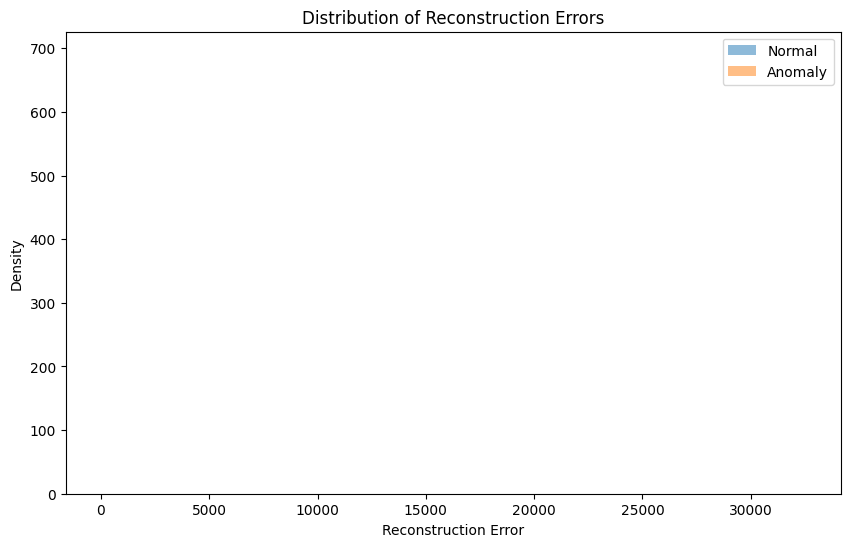

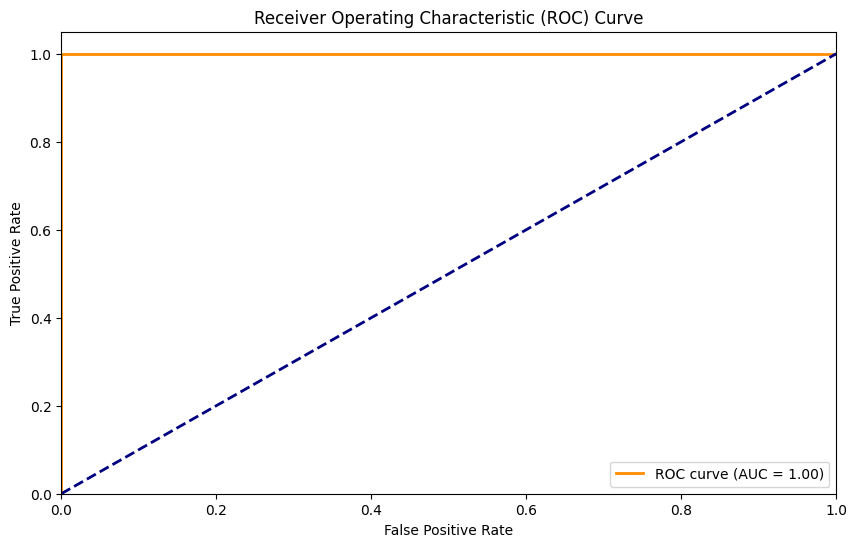

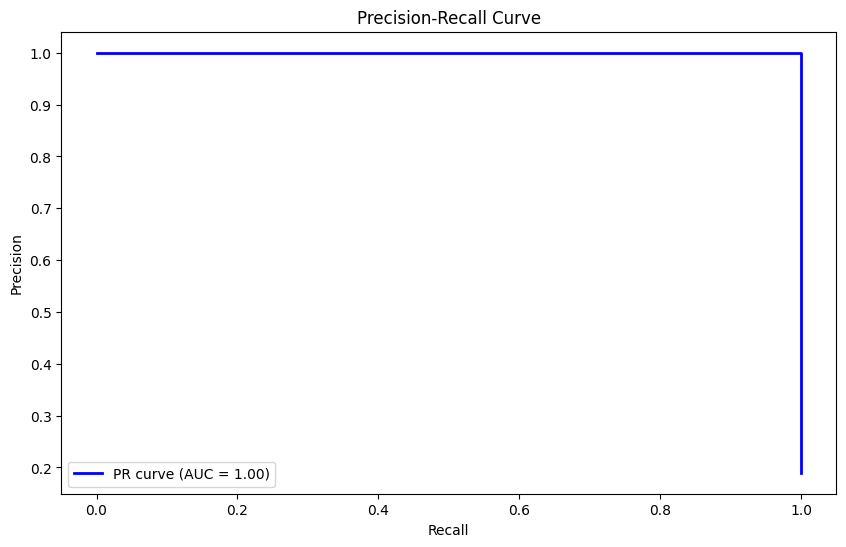

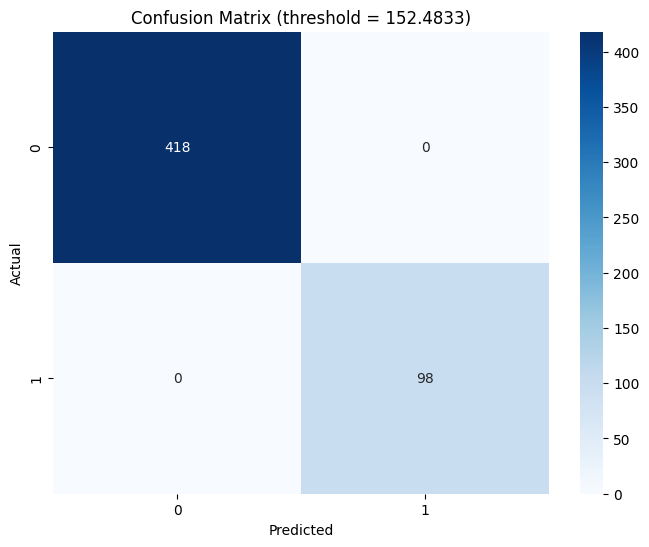


Performance Metrics:
Optimal Threshold: 152.4833
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Evaluation Results:
Optimal Threshold: 152.4833
ROC AUC: 1.0000
PR AUC: 1.0000
F1 Score: 1.0000


In [18]:
# 4. 최상의 모델 불러오기 (train_model 함수에서 저장된 모델)
model = load_trained_model(
    model=model,
    model_path=model_path,
    device=device
)

# 5. 모델 평가
results = evaluate_model(
    model=model,
    test_loader=test_loader,
    test_labels=test_labels,
    device=device
)

# 6. 결과 확인
print("\nEvaluation Results:")
print(f"Optimal Threshold: {results['optimal_threshold']:.4f}")
print(f"ROC AUC: {results['roc_auc']:.4f}")
print(f"PR AUC: {results['pr_auc']:.4f}")
print(f"F1 Score: {results['f1_score']:.4f}")